In [1]:

#https://github.com/ekehoe32/orthrus
import sys
sys.path.append('/home/katrina/a/mankovic/ZOETIS/Fall2021/Orthrus/orthrus')
import orthrus
from orthrus import core
from orthrus.core import dataset
import numpy as np
from NetworkDataAnalysis import graph_tools_construction as gt
from matplotlib import pyplot as plt
import pandas
# from orthrus.core.pipeline import *
from orthrus.core.pipeline import load_object
from sklearn.preprocessing import FunctionTransformer
from orthrus.preprocessing.imputation import HalfMinimum
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
import pylab


dataroot = '/data4/mankovic/'

An initial analysis of the Z40 dataset using the features found by Kartikay Sharma

Last edited on: 10/1/21

Resilts presented on: 

In [2]:
#load data
f_ranks = load_object(dataroot+'De-Identified_CZ/z40_f_ranks.pickle')
feature_ids = f_ranks['frequency'] > 1
featureset_randIDs = list(f_ranks[feature_ids].index)

Z40_dataset = dataset.load_dataset(dataroot+'De-Identified_CZ/DeId_TPM_C1_Z40_Z34.ds')
Z40_dataset.metadata = Z40_dataset.metadata.query("Project == 'Z40' & Treatment == 'High' & Timepoint == 0.0")
sidx = list(Z40_dataset.metadata.index)
Z40_dataset.data = Z40_dataset.data.loc[sidx][featureset_randIDs]

transform = make_pipeline(HalfMinimum(missing_values=0), FunctionTransformer(np.log2))
Z40_dataset.normalize(transform, norm_name='HalfMinimum + Log2')
Z40_data = Z40_dataset.data

4 responder and 4 non responder


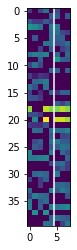

In [3]:
#sick healthy sorted X
healthy_seqID = list(Z40_dataset.metadata.query("Response == 0.0").index)
sick_seqID = list(Z40_dataset.metadata.query("Response == 1.0").index)
print(str(len(healthy_seqID))+' responder and ' +str(len(sick_seqID))+' non responder')
sorted_X = np.vstack([np.array(Z40_data.loc[healthy_seqID]), np.array(Z40_data.loc[sick_seqID])])
plt.imshow(sorted_X[:,:40].T)
plt.axvline(4.5,  color = 'white')


In [4]:
frequencies = []
gene_ids = list(Z40_data.loc[healthy_seqID].columns)
for g in gene_ids:
    frequencies.append(f_ranks[f_ranks['frequency'] > 1].loc[g]['frequency'])
    

## Run this for Responder and Non-Responder Networks

In [5]:
#cast the data as a numpy array
X = sorted_X.copy()
m = X.shape[1]

### Correlation Network

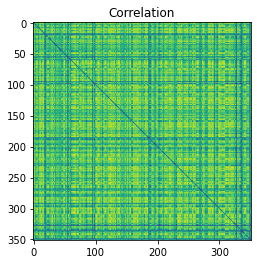

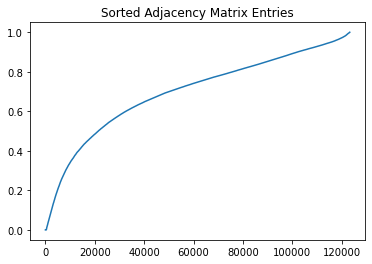

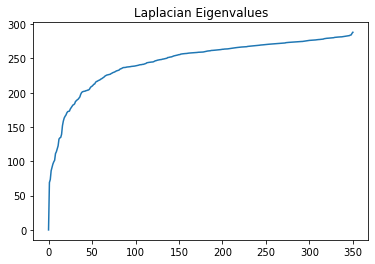

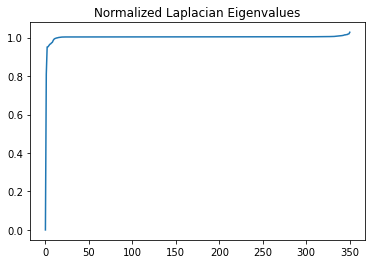

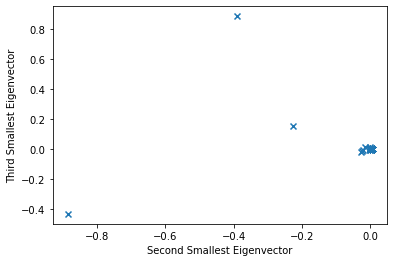

In [6]:
#generate adjacency matrix
similarity = 'correlation'
A = gt.adjacency_matrix(X,similarity)


#calculate the laplacian
incident_edges = np.sum(A,axis = 1)
#degree matrix
D = np.diag(incident_edges)*np.eye(m)
L = D-A

#calculate the normalized laplacian
snD = np.diag(1/np.sqrt(incident_edges))*np.eye(m)
Ln = snD @ (D-A) @ snD


#plots
plt.figure()
plt.imshow(A)
plt.title('Correlation')

plt.figure('A')
plt.title('Sorted Adjacency Matrix Entries')
plt.plot(np.sort(A.flatten()))

plt.figure('L')
plt.title('Laplacian Eigenvalues')
plt.plot(np.linalg.eigh(L)[0])

plt.figure('Ln')
plt.title('Normalized Laplacian Eigenvalues')
plt.plot(np.linalg.eigh(Ln)[0])


A_threshhold = A.copy()
A_threshhold[np.where(A_threshhold < .5)] = 0
A_threshhold[np.where(A_threshhold >= .5)] = 1
gt.embedgraph(A_threshhold)

array([[-1.35145192e-03,  2.42324039e-04],
       [-3.90545158e-04,  1.31057103e-02],
       [-1.83830309e-04,  1.39762169e-02],
       [ 4.34791540e-03,  3.65391829e-05],
       [-3.47444353e-03,  1.35685050e-04],
       [-1.06766000e-02,  1.27416424e-02],
       [ 5.73976398e-03,  6.64905612e-04],
       [ 4.55494046e-03,  1.31707316e-03],
       [ 3.90911426e-04,  4.45307641e-03],
       [-1.75094150e-02,  3.92581145e-02]])

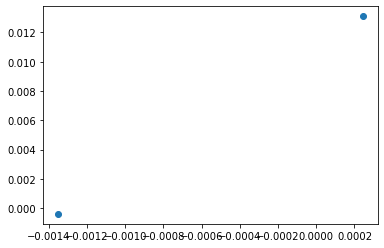

In [7]:

_, evecs = np.linalg.eigh(L)

embedding = np.vstack([evecs[:,1], evecs[:,2]])

smaller_embedding = []
for i in range(embedding.shape[1]):
    if np.abs(embedding[0,i]) < .5 and np.abs(embedding[1,i]) < .5 and embedding[1,i]>0:
        smaller_embedding.append(embedding[:,i])
        
smaller_embedding = np.vstack(smaller_embedding)
plt.scatter(smaller_embedding[0,:], smaller_embedding[1,:])
smaller_embedding

In [8]:
#choose whether or not we're using the normalized laplacian
not_normalized_laplacian = False

nodes = np.arange(m)

clst_adj_cor = []
clst_node_cor = []
all_clusters_node_cor = []

#do highearchical bipartitioning using fiedler vector
gt.cluster_laplace(A, clst_adj_cor, nodes, 1, clst_node_cor, all_clusters_node_cor, fiedler_switch =not_normalized_laplacian)



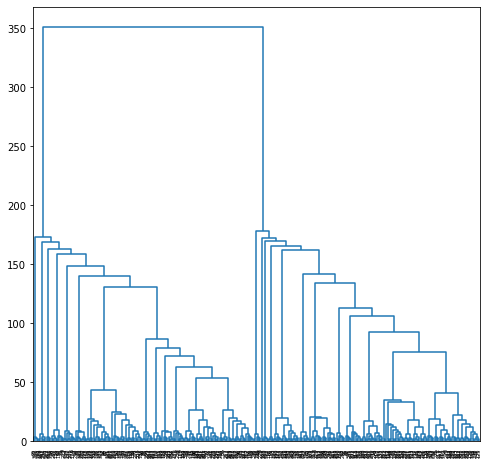

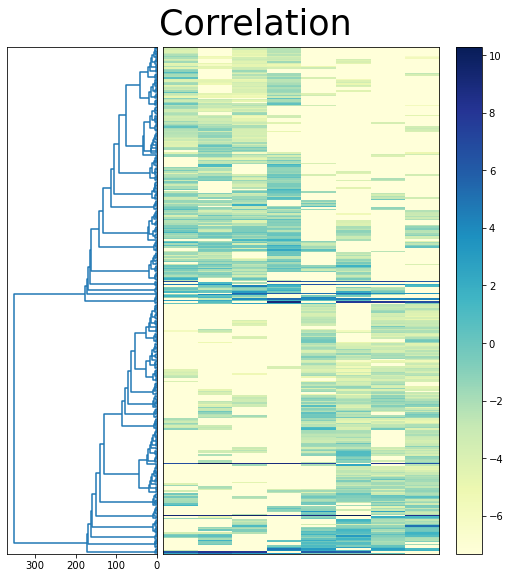

In [9]:
#plot the dendrogram
for jd in [True, False]:
    den = gt.plot_dendrogram(all_clusters_node_cor, A, sorted_X, clst_dst = 'dumb', fname = 'delete_me.png', title='Correlation', just_dendrogram = jd, split = 4)

3.466292134831461 3.7745664739884393


Text(0.5, 1.0, 'Cluster 1')

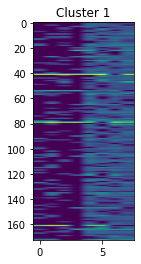

In [10]:
Z_cor = gt.linkage_matrix(all_clusters_node_cor, A, 'dumb')
c = 1

#find out average frequency of features in the cluster
number_clusters = 2

labels = gt.cut_tree(Z_cor, n_clusters = number_clusters)
print(np.mean([frequencies[i] for i in np.where(labels == 0)[0]]), np.mean([frequencies[i] for i in np.where(labels == 1)[0]])) 
plt.imshow(sorted_X[:,np.where(labels == c)[0]].T, aspect=.1)
plt.title('Cluster '+str(c))
# len(np.where(labels == 1)[0]), [frequencies[i] for i in np.where(labels == 1)[0]]

In [11]:
Z_cor = gt.linkage_matrix(all_clusters_node_cor, A, 'dumb')


#find out average frequency of features in the cluster
number_clusters = 9

labels = gt.cut_tree(Z_cor, n_clusters = number_clusters)

print('mean frequency of features in cluster')
for l in range(9):
    print('cluster '+str(l)+' is: '+str(np.mean([frequencies[i] for i in np.where(labels == l)[0]])))

mean frequency of features in cluster
cluster 0 is: 3.4444444444444446
cluster 1 is: 3.6855345911949686
cluster 2 is: 3.6666666666666665
cluster 3 is: 4.25
cluster 4 is: 6.0
cluster 5 is: 3.5
cluster 6 is: 3.5
cluster 7 is: 5.5
cluster 8 is: 3.0


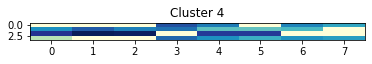

In [12]:
c=4

plt.imshow(sorted_X[:,np.where(labels == c)[0]].T, aspect=.1, cmap=pylab.cm.YlGnBu)
plt.title('Cluster '+str(c))
# len(np.where(labels == 1)[0]), [frequencies[i] for i in np.where(labels == 1)[0]]
plt.savefig('c4_cor.png')

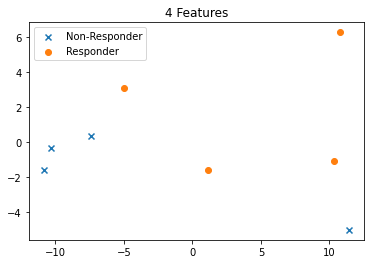

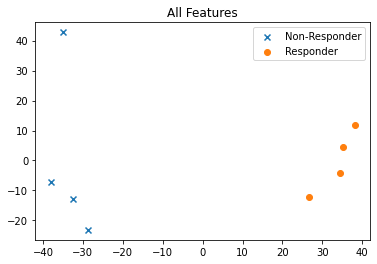

In [13]:
# %matplotlib inline

#plot a pca of the subjects using cluster number 2
idx = np.where(labels == 4)[0]

pca = PCA(n_components = 2)
embedding = pca.fit_transform(X[:,idx])

plt.figure()
idx_none = [0,1,2,3]
idx_high = [4,5,6,7]
plt.scatter(embedding[idx_none,0], embedding[idx_none,1], label = 'Non-Responder', marker = 'x')
plt.scatter(embedding[idx_high,0], embedding[idx_high,1], label = 'Responder', marker = 'o')
plt.title(str(len(idx))+ ' Features')
plt.legend()
plt.savefig('c4_pca.png')

pca = PCA(n_components = 2)
embedding = pca.fit_transform(X)

plt.figure()
plt.title('All Features')
plt.scatter(embedding[idx_none,0], embedding[idx_none,1], label = 'Non-Responder', marker = 'x')
plt.scatter(embedding[idx_high,0], embedding[idx_high,1], label = 'Responder', marker = 'o')
plt.legend()
plt.savefig('all_pca.png')


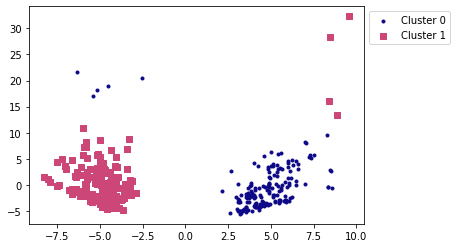

In [14]:

#calculate linkage matrix
Z_cor = gt.linkage_matrix(all_clusters_node_cor, A, 'dumb')


#plot some of the most distinct clusters
number_clusters = 2

labels = gt.cut_tree(Z_cor, n_clusters = number_clusters)
pca = PCA(n_components = 2)
embedding = pca.fit_transform(X.T)

markers = [".",",","o","v","^","<",">","1","2","3","4","8","s","p","P","*","h","H","+","x","X","D","d","|","_"]

color_list = plt.get_cmap('plasma').colors

n_colors = len(color_list)

c_sampler = [i*(n_colors//number_clusters) for i in range(number_clusters)]


for i in range(0,number_clusters,1):
    idx = np.where(labels == i)[0]

    # plt.scatter(embedding[idx,0],embedding[idx,1], color = colors[i % 5], marker = markers[i % 5], label = 'Cluster '+str(i))
    plt.scatter(embedding[idx,0],embedding[idx,1], color = color_list[c_sampler[i]], marker = markers[i], label = 'Cluster '+str(i))

plt.legend(loc="upper left", bbox_to_anchor=(1,1))


plt.savefig('cor_pca.png', bbox_inches='tight')


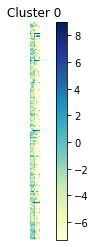

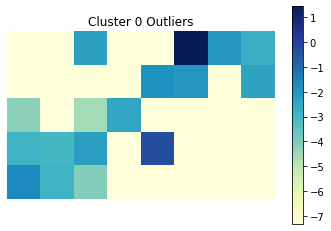

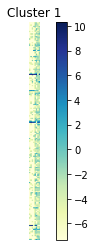

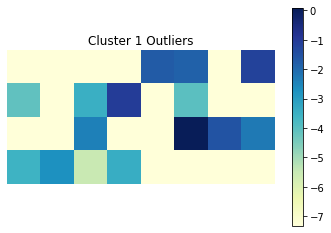

In [15]:
for i in range(0,number_clusters,1):
    idx = np.where(labels == i)[0]
    idx_outlier = np.where(embedding[idx,1]>11)[0]
    plt.figure()
    plt.imshow(sorted_X[:,idx].T, cmap=pylab.cm.YlGnBu)
    plt.axis('off')
    plt.title('Cluster '+str(i))
    plt.colorbar()
    plt.figure()
    plt.imshow(sorted_X[:,idx_outlier].T, cmap=pylab.cm.YlGnBu)
    plt.axis('off')
    plt.title('Cluster '+str(i)+ ' Outliers')
    plt.colorbar()
    # plt.xlabel('Subject')
    # plt.ylabel('Gene')

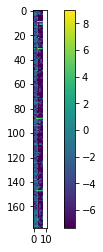

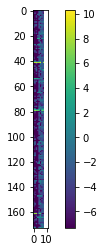

In [16]:

for i in range(2):
    plt.figure()
    idx = np.where(labels == i)[0]
    plt.imshow(sorted_X[:,idx].T)
    plt.axvline(10.5, color = 'white')
    plt.colorbar()

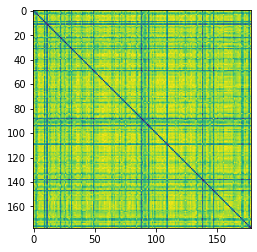

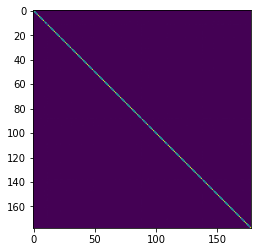

In [17]:
the_cluster = np.where(labels == 0)[0]
n_nodes = len(the_cluster)
small_A = np.zeros((n_nodes,n_nodes))
for i in range(n_nodes):
    for j in range(n_nodes):
        small_A[i,j] = A[the_cluster[i],the_cluster[j]]

plt.figure()
plt.imshow(small_A)

plt.figure()
D = np.diag(np.sum(small_A,axis=1))
plt.imshow(D-small_A)



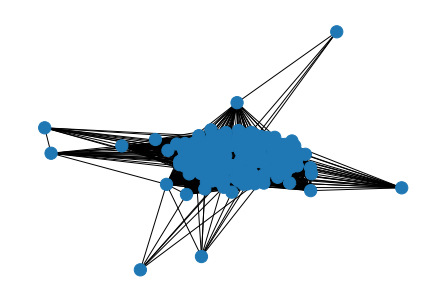

In [18]:
node_sizes = np.ones(n_nodes)*150

new_A = small_A.copy()
new_A[np.where(new_A < .6)] = 0



gt.displaygraph(new_A, node_sizes, layout = 'spring')

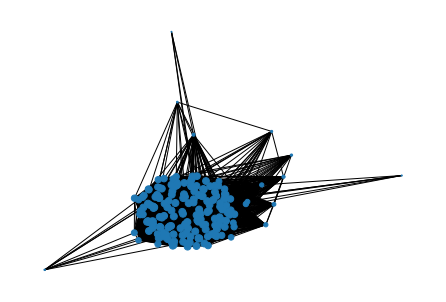

In [19]:
scores = gt.centrality_scores(new_A, 'degree')
gt.displaygraph(new_A, scores*50, layout = 'spring')

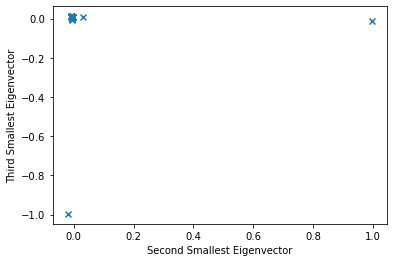

In [20]:
gt.embedgraph(new_A)

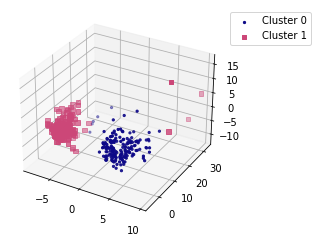

In [21]:
# %matplotlib notebook

#plot some of the most distinct clusters
number_clusters = 2

labels = gt.cut_tree(Z_cor, n_clusters =number_clusters)
pca = PCA(n_components = 3)
embedding = pca.fit_transform(X.T)

markers = [".",",","o","v","^","<",">","1","2","3","4","8","s","p","P","*","h","H","+","x","X","D","d","|","_"]

color_list = plt.get_cmap('plasma').colors

n_colors = len(color_list)

c_sampler = [i*(n_colors//number_clusters) for i in range(number_clusters)]
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for i in range(0,number_clusters,1):
    idx = np.where(labels == i)[0]
    # plt.scatter(embedding[idx,0],embedding[idx,1], color = colors[i % 5], marker = markers[i % 5], label = 'Cluster '+str(i))
    ax.scatter(embedding[idx,0],embedding[idx,1],embedding[idx,2], color = color_list[c_sampler[i]], marker = markers[i], label = 'Cluster '+str(i))

plt.legend(loc="upper left", bbox_to_anchor=(1,1))


In [22]:
labels

array([[0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
    

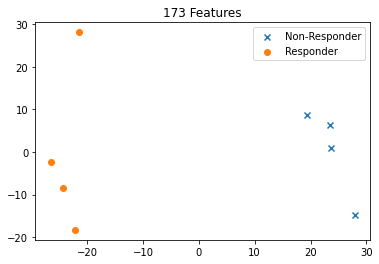

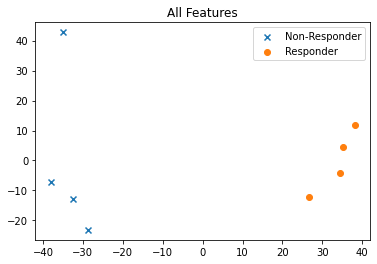

In [23]:
# %matplotlib inline

#plot a pca of the subjects using cluster number 2
idx = np.where(labels == 1)[0]

pca = PCA(n_components = 2)
embedding = pca.fit_transform(X[:,idx])

plt.figure()
idx_none = [0,1,2,3]
idx_high = [4,5,6,7]
plt.scatter(embedding[idx_none,0], embedding[idx_none,1], label = 'Non-Responder', marker = 'x')
plt.scatter(embedding[idx_high,0], embedding[idx_high,1], label = 'Responder', marker = 'o')
plt.title(str(len(idx))+ ' Features')
plt.legend()

pca = PCA(n_components = 2)
embedding = pca.fit_transform(X)

plt.figure()
plt.title('All Features')
plt.scatter(embedding[idx_none,0], embedding[idx_none,1], label = 'Non-Responder', marker = 'x')
plt.scatter(embedding[idx_high,0], embedding[idx_high,1], label = 'Responder', marker = 'o')
plt.legend()


### Heat Kernel

In [24]:
#parameter choices

similarity = 'heatkernel'
fname = 'delete_me.png'
title = 'synthetic_test'
m=X.shape[1]

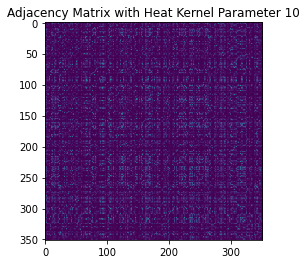

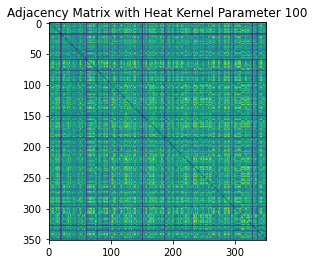

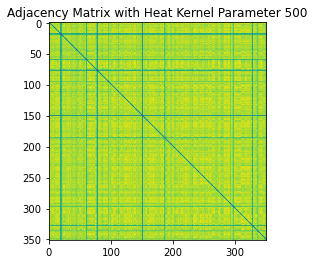

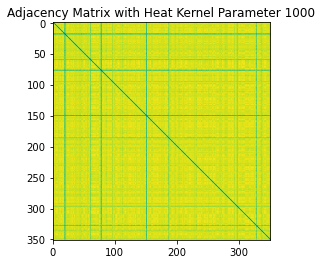

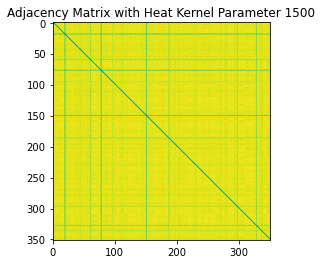

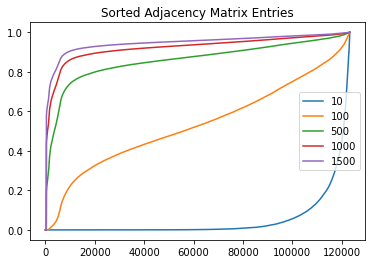

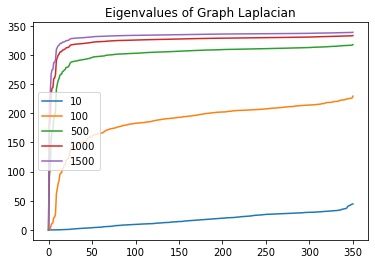

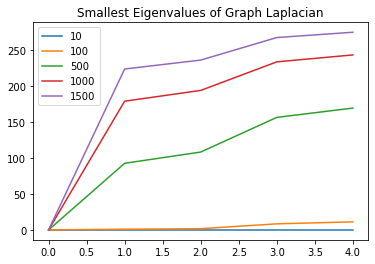

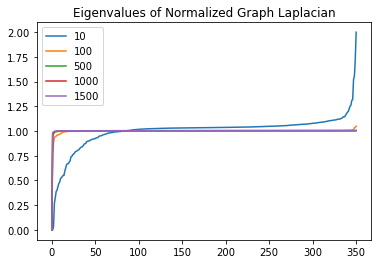

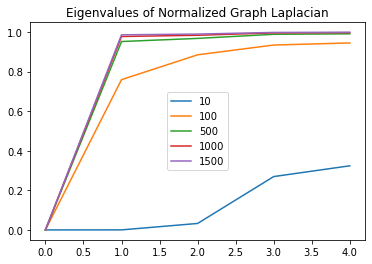

In [25]:
#plots for network with different heat kernel parameters


for hkp in [10, 100, 500, 1000, 1500]:

    A = gt.adjacency_matrix(X,similarity,h_k_param=hkp)

    plt.figure()
    plt.imshow(A)
    plt.title('Adjacency Matrix with Heat Kernel Parameter ' +str(hkp))

    #laplacian
    incident_edges = np.sum(A,axis = 1)
    #degree matrix
    D = np.diag(incident_edges)*np.eye(m)
    L = D-A

    #calculate the normalized laplacian
    snD = np.diag(1/np.sqrt(incident_edges))*np.eye(m)
    Ln = snD @ (D-A) @ snD

    

    plt.figure('A')
    plt.plot(np.sort(A.flatten()), label = str(hkp))
    plt.legend()
    plt.title('Sorted Adjacency Matrix Entries')

    plt.figure('L')
    plt.plot(np.linalg.eigh(L)[0], label = str(hkp))
    plt.legend()
    plt.title('Eigenvalues of Graph Laplacian')

    plt.figure('L_small')
    plt.plot(np.linalg.eigh(L)[0][:5], label = str(hkp))
    plt.legend()
    plt.title('Smallest Eigenvalues of Graph Laplacian')

    plt.figure('Ln')
    plt.plot(np.linalg.eigh(Ln)[0], label = str(hkp))
    plt.legend()
    plt.title('Eigenvalues of Normalized Graph Laplacian')

    plt.figure('Ln_small')
    plt.plot(np.linalg.eigh(Ln)[0][:5], label = str(hkp))
    plt.legend()
    plt.title('Eigenvalues of Normalized Graph Laplacian')




Text(0.5, 1.0, 'Heat Kernel')

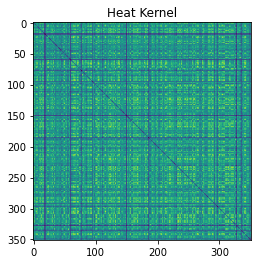

In [26]:
#we choose a heat kernel parameter of 100

A = gt.adjacency_matrix(X,similarity,h_k_param=100)

plt.figure
plt.imshow(A)
plt.title('Heat Kernel')

In [27]:
# gt.embedgraph(A[np.where(A >)])

In [28]:
#higherarchical bi-partitioning

#whether or not we'll use normalized graph laplacian
not_normalized_laplacian = True


nodes = np.arange(m)


clst_adj_hk = []
clst_node_hk = []
all_clusters_node_hk = []

gt.cluster_laplace(A, clst_adj_hk, nodes, 1, clst_node_hk, all_clusters_node_hk, fiedler_switch =not_normalized_laplacian)



In [29]:
sorted_X.shape

(8, 351)

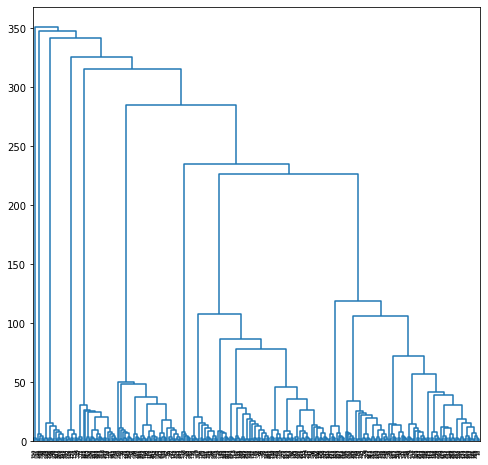

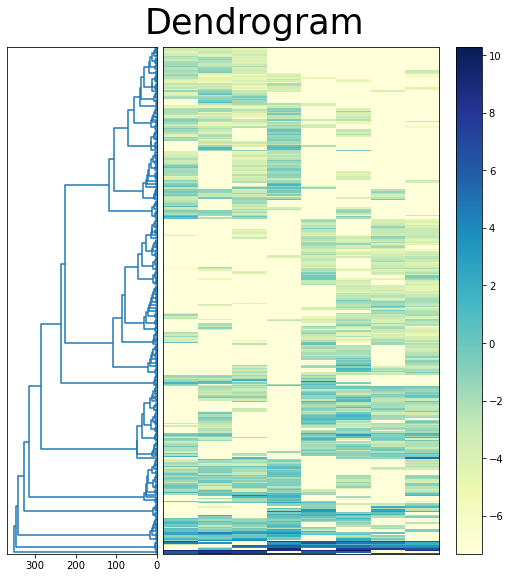

In [30]:
#plot dendrograms

for jd in [True, False]:
    gt.plot_dendrogram(all_clusters_node_hk, A, sorted_X, clst_dst = 'dumb', fname = 'delete_me.png', title='Dendrogram', just_dendrogram = jd, split = 11)


In [13]:
Z_hk = gt.linkage_matrix(all_clusters_node_hk, A, 'dumb')


#find out average frequency of features in the cluster
number_clusters = 9

labels = gt.cut_tree(Z_hk, n_clusters = number_clusters)

print('mean frequency of features in cluster')
for l in range(number_clusters):
    print('cluster '+str(l)+' is: '+str(np.mean([frequencies[i] for i in np.where(labels == l)[0]])))

mean frequency of features in cluster
cluster 0 is: 3.319327731092437
cluster 1 is: 3.5462962962962963
cluster 2 is: 2.375
cluster 3 is: 3.6
cluster 4 is: 3.935483870967742
cluster 5 is: 4.833333333333333
cluster 6 is: 4.14
cluster 7 is: 4.1875
cluster 8 is: 4.0


/tmp/ipykernel_44951/1685685928.py:1: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
  plt.imshow(sorted_X[:,np.where(labels == 22)[0]].T)


(0, [3, 5, 7, 5, 2, 2, 6, 4, 3, 5, 2, 5, 2, 3, 8, 5])

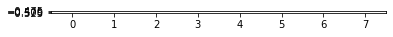

In [38]:
plt.imshow(sorted_X[:,np.where(labels == 22)[0]].T)
len(np.where(labels == 22)[0]), [frequencies[i] for i in np.where(labels == 7)[0]]

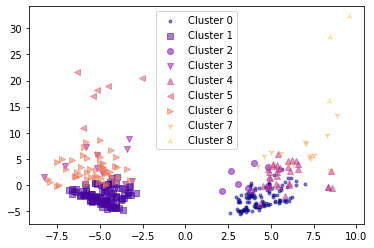

In [40]:
#cut tree to get most distinct clusters
number_clusters = 9


#linkage matrix
Z_hk= gt.linkage_matrix(all_clusters_node_hk, A, 'dumb')

#cut it
labels = gt.cut_tree(Z_hk, n_clusters = number_clusters)

#PCA of genes labeled by cluster
pca = PCA(n_components = 2)
embedding = pca.fit_transform(X.T)

markers = [".",",","o","v","^","<",">","1","2","3","4","8","s","p","P","*","h","H","+","x","X","D","d","|","_"]

color_list = plt.get_cmap('plasma').colors

n_colors = len(color_list)

c_sampler = [i*(n_colors//number_clusters) for i in range(number_clusters)]

for i in range(0,number_clusters,1):
    idx = np.where(labels == i)[0]
    plt.scatter(embedding[idx,0],embedding[idx,1], color = color_list[c_sampler[i]], marker = markers[i], label = 'Cluster '+str(i), alpha = .5)

plt.legend()
plt.savefig('hk_pca.png')


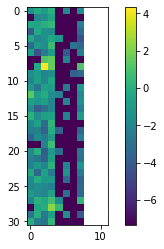

In [49]:
#cluster number 3
idx = np.where(labels == 4)[0]
plt.imshow(sorted_X[:,idx].T)
plt.vlines(10.5, 0,len(idx)-1, color = 'white')
plt.colorbar()

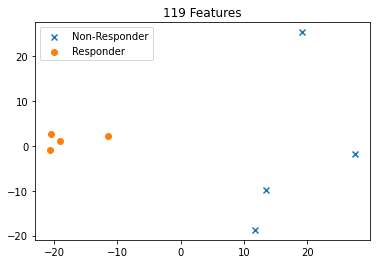

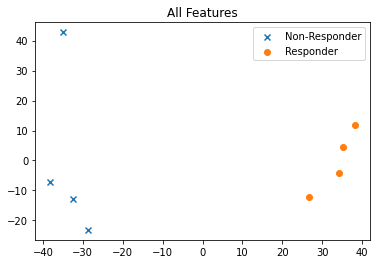

In [50]:
# %matplotlib inline

#plot a pca of the subjects using cluster number 2
idx = np.where(labels == 0)[0]

pca = PCA(n_components = 2)
embedding = pca.fit_transform(X[:,idx])

plt.figure()
idx_none = [0,1,2,3]
idx_high = [4,5,6,7]
plt.scatter(embedding[idx_none,0], embedding[idx_none,1], label = 'Non-Responder', marker = 'x')
plt.scatter(embedding[idx_high,0], embedding[idx_high,1], label = 'Responder', marker = 'o')
plt.title(str(len(idx))+ ' Features')
plt.legend()

pca = PCA(n_components = 2)
embedding = pca.fit_transform(X)

plt.figure()
plt.title('All Features')
plt.scatter(embedding[idx_none,0], embedding[idx_none,1], label = 'Non-Responder', marker = 'x')
plt.scatter(embedding[idx_high,0], embedding[idx_high,1], label = 'Responder', marker = 'o')
plt.legend()


## Just Sick Subjects for Network Generation

## Just Healthy Subjects for Network Generation